# Introduction to Feature Engineering

**Learning Objectives**
  * Improve the accuracy of a model by using feature engineering
  * Understand there's two places to do feature engineering in Tensorflow
    1. Using the `tf.feature_column` module
    2. In the input functions
    
## Introduction

Up until now we've been focusing on Tensorflow mechanics to make sure our code works, we have neglected model performance, which at this point is **9.26 RMSE**. 

In this notebook we'll attempt to improve on that using feature engineering.

In [1]:
# Ensure that we have Tensorflow 1.13 installed.
!pip3 freeze | grep tensorflow==1.13.1 || pip3 install tensorflow==1.13.1

tensorflow==1.13.1


In [2]:
import tensorflow as tf
import math
import numpy as np
import shutil
print(tf.__version__)

1.13.1


## Load raw data

These are the same files created in the `create_datasets.ipynb` notebook

In [3]:
!gsutil cp gs://cloud-training-demos/taxifare/small/*.csv .
!ls -l *.csv

Copying gs://cloud-training-demos/taxifare/small/taxi-test.csv...
Copying gs://cloud-training-demos/taxifare/small/taxi-train.csv...
Copying gs://cloud-training-demos/taxifare/small/taxi-valid.csv...
/ [3 files][ 10.9 MiB/ 10.9 MiB]                                                
Operation completed over 3 objects/10.9 MiB.                                     
-rw-r--r-- 1 jupyter jupyter 1799474 Jul 18 17:17 taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 7986353 Jul 18 17:17 taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 1673742 Jul 18 17:17 taxi-valid.csv


In [35]:
# do this to actually look at the features

In [28]:
import pandas as pd
df = pd.read_csv("taxi-train.csv")

In [30]:
df['latdiff'] = df['pickuplat'] - df['dropofflat']
df['londiff'] = df['pickuplon'] - df['dropofflon']

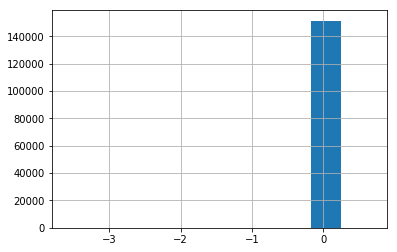

In [34]:
df['latdiff'].hist()

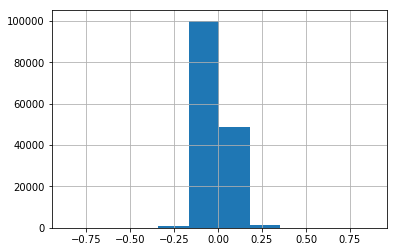

In [33]:
df['londiff'].hist()

## Train and Evaluate input functions

These are the same as before with one additional line of code: a call to `add_engineered_features()` from within the `_parse_row()` function.

In [4]:
CSV_COLUMN_NAMES = ["fare_amount","dayofweek","hourofday","pickuplon","pickuplat","dropofflon","dropofflat"]
CSV_DEFAULTS = [[0.0],[1],[0],[-74.0],[40.0],[-74.0],[40.7]]

def read_dataset(csv_path):
    def _parse_row(row):
        # Decode the CSV row into list of TF tensors
        fields = tf.decode_csv(records = row, record_defaults = CSV_DEFAULTS)

        # Pack the result into a dictionary
        features = dict(zip(CSV_COLUMN_NAMES, fields))
        
        # NEW: Add engineered features
        features = add_engineered_features(features)
        
        # Separate the label from the features
        label = features.pop("fare_amount") # remove label from features and store

        return features, label
    
    # Create a dataset containing the text lines.
    dataset = tf.data.Dataset.list_files(file_pattern = csv_path) # (i.e. data_file_*.csv)
    dataset = dataset.flat_map(map_func = lambda filename:tf.data.TextLineDataset(filenames = filename).skip(count = 1))

    # Parse each CSV row into correct (features,label) format for Estimator API
    dataset = dataset.map(map_func = _parse_row)
    
    return dataset

def train_input_fn(csv_path, batch_size = 128):
    #1. Convert CSV into tf.data.Dataset with (features,label) format
    dataset = read_dataset(csv_path)
      
    #2. Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(buffer_size = 1000).repeat(count = None).batch(batch_size = batch_size)
   
    return dataset

def eval_input_fn(csv_path, batch_size = 128):
    #1. Convert CSV into tf.data.Dataset with (features,label) format
    dataset = read_dataset(csv_path)

    #2.Batch the examples.
    dataset = dataset.batch(batch_size = batch_size)
   
    return dataset

## Feature Engineering: feature columns

There are two places in Tensorflow where we can do feature engineering. The first is using the `tf.feature_column` package. This allows us easily 

- bucketize continuous features
- one hot encode categorical features
- create feature crosses

For details on the possible `tf.feature_column` transformations and when to use each see the [official guide](https://www.tensorflow.org/guide/feature_columns).

Let's use `tf.feature_column` to create a feature that shows the combination of day of week and hour of day. This will allow our model to easily learn the difference between say Wednesday at 5pm (rush hour, expect higher fares) and Sunday at 5pm (light traffic, expect lower fares).

Let's also use it to bucketize our latitudes and longitudes because treating them as continuous numbers is misleading to the model.

#### **Exercise 1**

Complete the code in the cell below by adding the necessary `tf.feature_column`s. There are many different feature columns you can use. Have a look at [the various feature columns](https://www.tensorflow.org/api_docs/python/tf/feature_column) and follow the links to the relevant documentation. 

**Hint**: For the `dayofweek` and `hourofday` you'll want to use categorical features. Then have a look at how categorical features can be combined to created a crossed column for `fc_day_hr`. Lastly, look at the implementation of `tf.feature_column.bucketized_column` to apply for the pickup and dropff latitude and longitude.

In [43]:
vocab = {}
vocab['dayofweek'] = [i for i in range(7)]
vocab['hourofday'] = [i for i in range(24)]

# 1. One hot encode dayofweek and hourofday
fc_dayofweek = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key='dayofweek',vocabulary_list=vocab['dayofweek']))
fc_hourofday = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key='hourofday', vocabulary_list=vocab['hourofday']))

# 2. Bucketize latitudes and longitude
NBUCKETS = 16
latbuckets = np.linspace(start = 38.0, stop = 42.0, num = NBUCKETS).tolist()
lonbuckets = np.linspace(start = -76.0, stop = -72.0, num = NBUCKETS).tolist()
fc_bucketized_plat = tf.feature_column.bucketized_column(source_column = tf.feature_column.numeric_column('pickuplat'), boundaries = latbuckets)
fc_bucketized_plon = tf.feature_column.bucketized_column(source_column = tf.feature_column.numeric_column('dropofflat'), boundaries = latbuckets)
fc_bucketized_dlat = tf.feature_column.bucketized_column(source_column = tf.feature_column.numeric_column('pickuplon'), boundaries = lonbuckets)
fc_bucketized_dlon = tf.feature_column.bucketized_column(source_column = tf.feature_column.numeric_column('dropofflon'), boundaries = lonbuckets)

signedbuckets = [-5,0,5]

fc_northsouth = tf.feature_column.bucketized_column(source_column = tf.feature_column.numeric_column(key='latdiff'), boundaries = signedbuckets)
fc_eastwest = tf.feature_column.bucketized_column(source_column = tf.feature_column.numeric_column(key='londiff'), boundaries = signedbuckets)

# 3. Cross features to get combination of day and hour
fc_crossed_day_hr = tf.feature_column.indicator_column(tf.feature_column.crossed_column(keys=['dayofweek', 'hourofday'], 
                                                                                        hash_bucket_size=len(vocab['dayofweek'] * len(vocab['hourofday']))))

fc_crossed_ns_hr = tf.feature_column.indicator_column(tf.feature_column.crossed_column(keys=['hourofday', 'northsouth'],
                                                                                        hash_bucket_size=len(vocab['hourofday'] * 2)))

fc_crossed_ew_hr = tf.feature_column.indicator_column(tf.feature_column.crossed_column(keys=['hourofday', 'eastwest'],
                                                                                        hash_bucket_size=len(vocab['hourofday'] * 2)))

## Feature Engineering: input functions

While feature columns are very powerful, what happens when we want to something that there isn't a feature column for?

Recall the input functions recieve csv data, format it, then pass it batch by batch to the model. We can also use input functions to inject arbitrary tensorflow code to manipulate the data.

However, we need to be careful that any transformations we do in one input function, we do for all, otherwise we'll have [training-serving skew](https://developers.google.com/machine-learning/guides/rules-of-ml/#training-serving_skew).

To guard against this we encapsulate all input function feature engineering in a single function, `add_engineered_features()`, and call this function from every input function.

Let's calculate the euclidean distance between the pickup and dropoff points and feed that as a new feature to our model. 

Also it may be useful to know which cardinal direction that distance is in. I suspect that distance is cheaper to travel North/South because in Manhatten streets that run North/South have less stops than streets that run East/West.

#### **Exercise 2**

In the next cell, you're asked to create some new engineered features using the `add_engineered_features` function below. 

This function takes a *dictionary* of features and returns the dictionary with some additional features added.
We want to engineer a new feature which captures the Euclidean distance (the straight-line distance) between the pickup and dropoff. Complete the code below to compute the 
difference in the latitude and the difference in the longitude. Then, use these to compute the Euclidean distance and add that to the features dictionary as well.

In [36]:
def add_engineered_features(features):
    features["dayofweek"] = features["dayofweek"] - 1 # subtract one since our days of week are 1-7 instead of 0-6
    
    features["latdiff"] = features['pickuplat'] - features['dropofflat']
    features["londiff"] = features['pickuplon'] - features['dropofflon']
    features["mandist"] = abs(features["latdiff"]) + abs(features['londiff'])
    #features["euclidean_dist"] = (features['latdiff']**2 + features['londiff']**2)**0.5

    return features

## Gather list of feature columns

Ultimately our estimator expects a list of feature columns, so let's gather all our engineered features into a single list.

We cannot pass categorical or crossed feature columns directly into a DNN, Tensorflow will give us an error. We must first wrap them using either `indicator_column()` or `embedding_column()`. The former will pass through the one-hot encoded representation as is, the latter will embed the feature into a dense representation of specified dimensionality (the 4th root of the number of categories is a good starting point for number of dimensions). Read more about indicator and embedding columns [here](https://www.tensorflow.org/guide/feature_columns#indicator_and_embedding_columns).


#### **Exercise 3**

In the code cell below, create a list containing all the necessary feature columns for our model, including the new feature columns we created above. 

**Hint**: You will need to use an `indicator_column()` to wrap any categorial or crossed feature columns. Take a look at [the documentation for `tf.feature_column.indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column).


In [44]:
feature_cols = [
    fc_dayofweek,
    fc_hourofday,
    fc_bucketized_plat,
    fc_bucketized_plon,
    fc_bucketized_dlat,
    fc_bucketized_dlon,
    fc_crossed_day_hr,
    fc_northsouth,
    fc_eastwest,
    tf.feature_column.numeric_column(key='latdiff'),
    tf.feature_column.numeric_column(key='londiff'),
    tf.feature_column.numeric_column(key='mandist')
    #tf.feature_column.numeric_column(key='euclidean_dist'),
#    fc_crossed_ns_hr,
#    fc_crossed_ew_hr
]

## Serving Input Receiver function 

The serving input receiver function will be the same as before except the received tensors are wrapped with `add_engineered_features()`.

#### **Exercise 4**

When building the `serving_input_receiver_fn()` we need to add our engineered features to the dictionary of `receiver_tensors` we will recieve at inference time. Complete the code below to achieve this by using the `add_engineered_features` function from above. 

Note that features should be a dictionary. Have a look at the documentation if you get stuck.

In [45]:
def serving_input_receiver_fn():
    receiver_tensors = {
        'dayofweek' : tf.placeholder(dtype = tf.int32, shape = [None]), # shape is vector to allow batch of requests
        'hourofday' : tf.placeholder(dtype = tf.int32, shape = [None]),
        'pickuplon' : tf.placeholder(dtype = tf.float32, shape = [None]), 
        'pickuplat' : tf.placeholder(dtype = tf.float32, shape = [None]),
        'dropofflat' : tf.placeholder(dtype = tf.float32, shape = [None]),
        'dropofflon' : tf.placeholder(dtype = tf.float32, shape = [None]),
    }
    
    features = add_engineered_features(receiver_tensors)
    
    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = receiver_tensors)

## Train and Evaluate (500 train steps)

The same as before, we'll train the model for 500 steps (sidenote: how many epochs do 500 trains steps represent?). Let's see how the engineered features we've added affect the performance. 

In [46]:
OUTDIR = "taxi_trained_dnn"

get_ipython().system_raw(
    "tensorboard --logdir {} --host 0.0.0.0 --port 6006 &"
    .format(OUTDIR)
)

get_ipython().system_raw("../../02_tensorflow/assets/ngrok http 6006 &")

In [47]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://96c847c1.ngrok.io


In [48]:
%%time
OUTDIR = "taxi_trained_dnn/500"
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
tf.logging.set_verbosity(v = tf.logging.INFO) # so loss is printed during training

model = tf.estimator.DNNRegressor(
    hidden_units = [10,10], # specify neural architecture
    feature_columns = feature_cols, 
    model_dir = OUTDIR,
    config = tf.estimator.RunConfig(
        tf_random_seed = 1, # for reproducibility
        save_checkpoints_steps = 100 # checkpoint every N steps
    ) 
)

# Add custom evaluation metric
def my_rmse(labels, predictions):
    pred_values = tf.squeeze(input = predictions["predictions"], axis = -1)
    return {"rmse": tf.metrics.root_mean_squared_error(labels = labels, predictions = pred_values)}

model = tf.contrib.estimator.add_metrics(estimator = model, metric_fn = my_rmse) 
    
train_spec = tf.estimator.TrainSpec(
    input_fn = lambda: train_input_fn("./taxi-train.csv"),
    max_steps = 500)

exporter = tf.estimator.BestExporter(name = "exporter", serving_input_receiver_fn = serving_input_receiver_fn) # export SavedModel once at the end of training
# Note: alternatively use tf.estimator.BestExporter to export at every checkpoint that has lower loss than the previous checkpoint

eval_spec = tf.estimator.EvalSpec(
    input_fn = lambda: eval_input_fn("./taxi-valid.csv"),
    steps = None,
    start_delay_secs = 1, # wait at least N seconds before first evaluation (default 120)
    throttle_secs = 1, # wait at least N seconds before each subsequent evaluation (default 600)
    exporters = exporter) # export SavedModel once at the end of training

tf.estimator.train_and_evaluate(estimator = model, train_spec = train_spec, eval_spec = eval_spec)

INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_eval_distribute': None, '_save_checkpoints_steps': 100, '_experimental_distribute': None, '_task_type': 'worker', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': 1, '_num_worker_replicas': 1, '_model_dir': 'taxi_trained_dnn/500', '_save_summary_steps': 100, '_train_distribute': None, '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_device_fn': None, '_master': '', '_evaluation_master': '', '_is_chief': True, '_log_step_count_steps': 100, '_save_checkpoints_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb366b05898>, '_num_ps_replicas': 0, '_task_id': 0}
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_eval_distribute': None, '_save_checkpoints_steps': 100, '_experimental_distribute': N

({'average_loss': 36.76012,
  'global_step': 500,
  'label/mean': 11.229713,
  'loss': 4697.6187,
  'prediction/mean': 13.246745,
  'rmse': 6.0630126},
 [b'taxi_trained_dnn/500/export/exporter/1563475761'])

### Results

Our RMSE is now **5.94**, our first significant improvement! If we look at the RMSE trend in TensorBoard it appears the model is still learning, so training past 500 steps would likely lower the RMSE even more. Let's run again, this time for 10x as many steps.

In [ ]:
# rmse was 6.17 euc, 6.34 man
# adding directionality gets 6.06

## Train and Evaluate (5,000 train steps)

Now, just as above, we'll execute a longer trianing job with 5,000 train steps using our engineered features and assess the performance.

In [49]:
%%time
OUTDIR = "taxi_trained_dnn/5000"
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
tf.logging.set_verbosity(v = tf.logging.INFO) # so loss is printed during training

model = tf.estimator.DNNRegressor(
    hidden_units = [10,10], # specify neural architecture
    feature_columns = feature_cols, 
    model_dir = OUTDIR,
    config = tf.estimator.RunConfig(
        tf_random_seed = 1, # for reproducibility
        save_checkpoints_steps = 100 # checkpoint every N steps
    ) 
)

# Add custom evaluation metric
def my_rmse(labels, predictions):
    pred_values = tf.squeeze(input = predictions["predictions"], axis = -1)
    return {"rmse": tf.metrics.root_mean_squared_error(labels = labels, predictions = pred_values)}

model = tf.contrib.estimator.add_metrics(estimator = model, metric_fn = my_rmse) 
    
train_spec = tf.estimator.TrainSpec(
    input_fn = lambda: train_input_fn("./taxi-train.csv"),
    max_steps = 5000)

exporter = tf.estimator.FinalExporter(name = "exporter", serving_input_receiver_fn = serving_input_receiver_fn) # export SavedModel once at the end of training
# Note: alternatively use tf.estimator.BestExporter to export at every checkpoint that has lower loss than the previous checkpoint

eval_spec = tf.estimator.EvalSpec(
    input_fn = lambda: eval_input_fn("./taxi-valid.csv"),
    steps = None,
    start_delay_secs = 1, # wait at least N seconds before first evaluation (default 120)
    throttle_secs = 1, # wait at least N seconds before each subsequent evaluation (default 600)
    exporters = exporter) # export SavedModel once at the end of training

tf.estimator.train_and_evaluate(estimator = model, train_spec = train_spec, eval_spec = eval_spec)

INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_eval_distribute': None, '_save_checkpoints_steps': 100, '_experimental_distribute': None, '_task_type': 'worker', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': 1, '_num_worker_replicas': 1, '_model_dir': 'taxi_trained_dnn/5000', '_save_summary_steps': 100, '_train_distribute': None, '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_device_fn': None, '_master': '', '_evaluation_master': '', '_is_chief': True, '_log_step_count_steps': 100, '_save_checkpoints_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb32d6ff1d0>, '_num_ps_replicas': 0, '_task_id': 0}
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_eval_distribute': None, '_save_checkpoints_steps': 100, '_experimental_distribute': 

({'average_loss': 24.833668,
  'global_step': 5000,
  'label/mean': 11.229713,
  'loss': 3173.5234,
  'prediction/mean': 9.183128,
  'rmse': 4.983339},
 [b'taxi_trained_dnn/5000/export/exporter/1563476090'])

### Results

Our RMSE is now **4.13**! It looks like RMSE may still be reducing, but training is getting slow so we should move to the cloud if we want to train longer.

Also we haven't explored our hyperparameters much. Is our neural architecture of two layers with 10 nodes each optimal? 

In the next notebook we'll explore this.

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License